### Finetuning Torchvision Models
(Author Nathan Inkawhich)

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version:",torch.__version__)
print("Torchvision Version:", torchvision.__version__)

PyTorch Version: 1.0.0
Torchvision Version: 0.2.1


In [2]:
data_dir = "data/hymenoptera_data"
model_name = "resnet"
num_classes = 2
batch_size = 8
num_epochs = 30
feature_extract = True

In [3]:
def train_model(model,dataloaders,criterion,optimizer,num_epochs = 25,is_inception=False):
    since = time.time()
    val_acc_history=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch: {}/{}'.format(epoch,num_epochs-1))
        print('-' * 20)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    if is_inception and phase == 'train':
                        outputs,aux_outputs = model(inputs)
                        loss1 = criterion(outputs,labels)
                        loss2 = criterion(aux_outputs,labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs,labels)
                    _,preds = torch.max(outputs,1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
        print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
            val_acc_history.append(epoch_acc)
    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m, {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        # Resnet18
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "alexnet":
        # Alexnet
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6]= nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "vgg":
        # VGG11_bn
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "squeezenet":
        # Squeezenet
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model.ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size = (1,1),stride = (1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_frts = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "inception":
        # Inception v3. Be careful, expects (299,299)sized images and has auxiliary output
        model_ft = models.inception_v3(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained = True)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

print("initializing Datasets and Dataloaders...")

image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train','val']}

dataloaders_dict = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size = batch_size,shuffle = True, num_workers = 4) 
                   for x in ['train','val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


initializing Datasets and Dataloaders...


In [7]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in model_ft.named_parameters():
        if param.requries_grad == True:
            print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [8]:
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion,optimizer_ft,
                            num_epochs = num_epochs, is_inception=(model_name =="inception"))

Epoch: 0/29
--------------------
val Loss:0.3393 Acc:0.9020
Epoch: 1/29
--------------------
val Loss:0.3301 Acc:0.8758
Epoch: 2/29
--------------------
val Loss:0.2450 Acc:0.9085
Epoch: 3/29
--------------------
val Loss:0.1999 Acc:0.9412
Epoch: 4/29
--------------------
val Loss:0.3142 Acc:0.8824
Epoch: 5/29
--------------------
val Loss:0.2415 Acc:0.9085
Epoch: 6/29
--------------------
val Loss:0.2405 Acc:0.9150
Epoch: 7/29
--------------------
val Loss:0.3032 Acc:0.8889
Epoch: 8/29
--------------------
val Loss:0.2276 Acc:0.9346
Epoch: 9/29
--------------------
val Loss:0.2393 Acc:0.9216
Epoch: 10/29
--------------------
val Loss:0.2412 Acc:0.9150
Epoch: 11/29
--------------------
val Loss:0.1822 Acc:0.9542
Epoch: 12/29
--------------------
val Loss:0.1986 Acc:0.9346
Epoch: 13/29
--------------------
val Loss:0.1997 Acc:0.9412
Epoch: 14/29
--------------------
val Loss:0.2347 Acc:0.9281
Epoch: 15/29
--------------------
val Loss:0.1912 Acc:0.9412
Epoch: 16/29
--------------------


Epoch: 0/29
--------------------
val Loss:0.6426 Acc:0.6928
Epoch: 1/29
--------------------
val Loss:0.7920 Acc:0.6405
Epoch: 2/29
--------------------
val Loss:0.5983 Acc:0.7059
Epoch: 3/29
--------------------
val Loss:0.7687 Acc:0.6144
Epoch: 4/29
--------------------
val Loss:0.5802 Acc:0.7516
Epoch: 5/29
--------------------
val Loss:0.5836 Acc:0.6667
Epoch: 6/29
--------------------
val Loss:0.5698 Acc:0.6928
Epoch: 7/29
--------------------
val Loss:0.5372 Acc:0.7255
Epoch: 8/29
--------------------
val Loss:0.8049 Acc:0.6732
Epoch: 9/29
--------------------
val Loss:0.6909 Acc:0.6209
Epoch: 10/29
--------------------
val Loss:0.5971 Acc:0.7124
Epoch: 11/29
--------------------
val Loss:0.6567 Acc:0.6667
Epoch: 12/29
--------------------
val Loss:0.5736 Acc:0.6993
Epoch: 13/29
--------------------
val Loss:0.8179 Acc:0.5817
Epoch: 14/29
--------------------
val Loss:0.7414 Acc:0.6667
Epoch: 15/29
--------------------
val Loss:0.6286 Acc:0.6928
Epoch: 16/29
--------------------


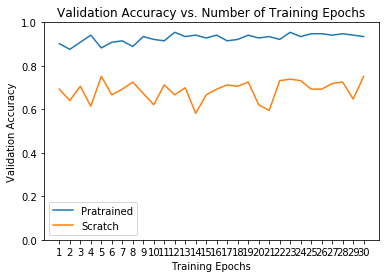

In [9]:
scratch_model, _ = initialize_model(model_name, num_classes, feature_extract= False, use_pretrained=False)
scratch_model =scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(),lr = 0.001, momentum = 0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion,scratch_optimizer,
                            num_epochs = num_epochs, is_inception = (model_name=="inception"))
ohist = []
shist = []
ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs +1),ohist,label="Pratrained")
plt.plot(range(1,num_epochs +1),shist,label = "Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1,num_epochs +1, 1.0))
plt.legend()
plt.show()